# Vienna data cube
TODO Link to metadata (source data, a/p metadata)

## Connect to s3 bucket

In [16]:
import s3fs
import xarray as xr
import rioxarray as rxr
from configparser import ConfigParser
import os
def config(filename, section='s3'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)
    # get section, default to postgresql
    s3 = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            s3[param[0]] = param[1]
    else:
        raise KeyError(
            f'Section {section} not found in {filename}. Did you specifiy the right path?')
    return s3


try:
    s3_config = config('../../database.ini')
   
except KeyError as er:
    print(er)
    print('Config file not found or malformed, trying with environment variables...')
    if (os.environ.get('S3_FAIRICUBE_STORAGE_BUCKET') is None):
        print('environment variables not set, contact the admin')
    else:
        s3_config = {
            's3_fairicube_storage_bucket': os.environ.get('S3_FAIRICUBE_STORAGE_BUCKET'),
            's3_fairicube_storage_key': os.environ.get('S3_FAIRICUBE_STORAGE_KEY'),
            's3_fairicube_storage_secret': os.environ.get('S3_FAIRICUBE_STORAGE_SECRET')}


In [17]:
s3fs_FS = s3fs.S3FileSystem(
    key=s3_config['s3_fairicube_storage_key'],
    secret=s3_config['s3_fairicube_storage_secret'],
)

## List cube dimensions

In [19]:
# TODO replace with STAC API code, once the data is registered to the FAIRiCUBE STAC Catalog
#https://stacapi.eoxhub.fairicube.eu/api

# List all files in the folder
files = s3fs_FS.ls('s3:///fairicube/vienna_data/100m/')

# Print the list of files
for file in files:
    print(file)

fairicube/vienna_data/100m/
fairicube/vienna_data/100m/RR_2020-01-01_2024-05-01_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/RR_yearly_avg_2020-2024_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/SA_2020-01-01_2024-05-01_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/SA_yearly_avg_2020-2024_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/TN_2020-01-01_2024-05-01_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/TN_yearly_avg_2020-2024_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/TX_2020-01-01_2024-05-01_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/TX_yearly_avg_2020-2024_epsg31256_100m_regridded.zarr
fairicube/vienna_data/100m/r00_admin_districts
fairicube/vienna_data/100m/r01_landuse
fairicube/vienna_data/100m/r02_dem
fairicube/vienna_data/100m/r03_biotones
fairicube/vienna_data/100m/r04_imp
fairicube/vienna_data/100m/r05_treecover
fairicube/vienna_data/100m/r06_protected_area
fairicube/vienna_data/100m/r07_water


## Load dimensions
### Spatiotemporal cube

In [24]:
# TODO replace with STAC API code, once the data is registered to the FAIRiCUBE STAC Catalog
# spatiotemporal cube - max daily 2m temperature
s3map = s3fs.S3Map(root='s3:///fairicube/vienna_data/100m/TN_2020-01-01_2024-05-01_epsg31256_100m_regridded.zarr', s3=s3fs_FS)
ds = xr.open_zarr(store=s3map)

### Thematic spatial cube

In [36]:
# land use
import pandas as pd
da = rxr.open_rasterio(s3fs_FS.open('s3://fairicube/vienna_data/100m/r01_landuse/r01_real_land_use2020_100m_b32_1_1.tif'))
# convert bands into data variables
ds_landuse = xr.merge([da[band].to_dataset(name=f'land_use{band+1}') for band in range(0,32)], compat='override')



ds_landuse

<xarray.Dataset>
Dimensions:      (x: 300, y: 230)
Coordinates:
    band         int32 1
  * x            (x) float64 -1.115e+04 -1.105e+04 ... 1.865e+04 1.875e+04
  * y            (y) float64 3.54e+05 3.538e+05 3.538e+05 ... 3.312e+05 3.31e+05
    spatial_ref  int32 0
Data variables: (12/32)
    land_use1    (y, x) float32 ...
    land_use2    (y, x) float32 ...
    land_use3    (y, x) float32 ...
    land_use4    (y, x) float32 ...
    land_use5    (y, x) float32 ...
    land_use6    (y, x) float32 ...
    ...           ...
    land_use27   (y, x) float32 ...
    land_use28   (y, x) float32 ...
    land_use29   (y, x) float32 ...
    land_use30   (y, x) float32 ...
    land_use31   (y, x) float32 ...
    land_use32   (y, x) float32 ...

#### Update CUBE (rename data variable names)

In [41]:
lut_land_use

,NUTZUNG_CODE,NUTZUNG_TEXT,NUTZUNG_L0,NUTZUNG_L1,FLY_indiciator
0,1,Baulandnutzung,Wohn- u. Mischnutzung (Schwerpunkt Wohnen),locker bebautes Wohn(misch)gebiet,2
1,2,Baulandnutzung,Wohn- u. Mischnutzung (Schwerpunkt Wohnen),Wohn(misch)gebiet mittlerer Dichte,1
2,3,Baulandnutzung,Wohn- u. Mischnutzung (Schwerpunkt Wohnen),dichtes Wohn(misch)gebiet,1
3,4,Baulandnutzung,Wohn- u. Mischnutzung (Schwerpunkt Wohnen),"grossvolumiger, solidaerer Wohn(misch)bau",1
4,5,Baulandnutzung,"Geschaefts,- Kern- und Mischnutzung (Schwerpun...",Buero- und Verwaltungsviertel,1
5,6,Baulandnutzung,"Geschaefts,- Kern- und Mischnutzung (Schwerpun...",solitaere Handelsstrukturen,1
6,7,Baulandnutzung,"Geschaefts,- Kern- und Mischnutzung (Schwerpun...","Geschaefts-, Kern- u. Mischgebiete",1
7,8,Baulandnutzung,"Geschaefts,- Kern- und Mischnutzung (Schwerpun...",Mischnutzung wenig dicht,1
8,9,Baulandnutzung,Industrie- und Gewerbenutzung,"Industrie, prod. Gewerbe, Grosshandel inkl. Lager",0
9,10,Baulandnutzung,soziale Infrastruktur,"Kultur, Freizeit, Messe",1


In [110]:
#

# read LookUpTable (lut)
lut_land_use =pd.read_csv(s3fs_FS.open('s3://fairicube/vienna_data/100m/r01_landuse/lut_realnutzung.csv'))
#lut_land_use


#update Data variables:
# List variables
variable_list = list(ds_landuse.keys()) 
for variable_in_list in variable_list:

    print (variable_in_list)
    band_numer = int(variable_in_list.split("land_use",1)[1])
    print ((band_numer))
    # set the index to be the names column
    
    result_row=lut_land_use[lut_land_use['NUTZUNG_CODE'] == band_numer]#.reset_index
    cell_value = result_row['NUTZUNG_L1'].values[0]
    print (cell_value)

    ds_landuse=ds_landuse.rename(name_dict={variable_in_list:cell_value})



land_use1
1
locker bebautes Wohn(misch)gebiet
land_use2
2
Wohn(misch)gebiet mittlerer Dichte
land_use3
3
dichtes Wohn(misch)gebiet
land_use4
4
grossvolumiger, solidaerer Wohn(misch)bau
land_use5
5
Buero- und Verwaltungsviertel
land_use6
6
solitaere Handelsstrukturen
land_use7
7
Geschaefts-, Kern- u. Mischgebiete
land_use8
8
Mischnutzung wenig dicht
land_use9
9
Industrie, prod. Gewerbe, Grosshandel inkl. Lager
land_use10
10
Kultur, Freizeit, Messe
land_use11
11
Gesundheit und Einsatzorg.
land_use12
12
Bildung
land_use13
13
Sport und Bad (Indoor)
land_use14
14
Militaerische Anlagen
land_use15
15
Klaeranlage, Deponie
land_use16
16
Energieversorgung u. Rundfunkanlagen
land_use17
17
Wasserversorgung
land_use18
18
Transformationsflaeche, Baustelle, Materialgew.
land_use19
19
Strassenraum begruent
land_use20
20
Strassenraum unbegruent
land_use21
21
Parkpluetze u. Parkhaeuser
land_use22
22
Bahnhoefe und Bahnanlagen
land_use23
23
Transport und Logistik inkl. Lager
land_use24
24
Park, Gruenanlag

In [111]:
ds_landuse

<xarray.Dataset>
Dimensions:                                            (x: 300, y: 230)
Coordinates:
    band                                               int32 1
  * x                                                  (x) float64 -1.115e+04...
  * y                                                  (y) float64 3.54e+05 ....
    spatial_ref                                        int32 0
Data variables: (12/32)
    locker bebautes Wohn(misch)gebiet                  (y, x) float32 ...
    Wohn(misch)gebiet mittlerer Dichte                 (y, x) float32 ...
    dichtes Wohn(misch)gebiet                          (y, x) float32 ...
    grossvolumiger, solidaerer Wohn(misch)bau          (y, x) float32 ...
    Buero- und Verwaltungsviertel                      (y, x) float32 ...
    solitaere Handelsstrukturen                        (y, x) float32 ...
    ...                                                 ...
    Acker                                              (y, x) float32 ...
    Weingarten                                         (y, x) float32 ...
    Gaertnerei, Obstplantagen                          (y, x) float32 ...
    Wald                                               (y, x) float32 ...
    Wiese                                              (y, x) float32 ...
    Gewaeser inkl. Bachbett                            (y, x) float32 ...

Map the land use "Park, Gruenanlage"

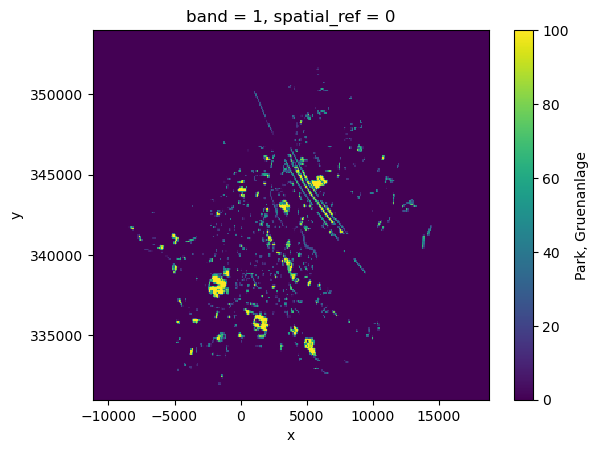

In [124]:

green_area = ds_landuse.get("Park, Gruenanlage")

#green_area_sum_area = green_area.sum()
green_area.plot()

What is the total area?

In [132]:
#print(green_area.sum(dim=['x','y']))
print ("total area [ha]")
print(green_area.values.sum() /100)

total area [ha]
1228.07


### Load next  CUBE (DEM)

In [133]:
# digital elevation model
da = rxr.open_rasterio(s3fs_FS.open('s3://fairicube/vienna_data/100m/r02_dem/r02_dem_mean_100m_b1_1_1.tif'))
ds_dem = da.drop_vars('band').squeeze().to_dataset(name='dem')
ds_dem

<xarray.Dataset>
Dimensions:      (x: 300, y: 230)
Coordinates:
  * x            (x) float64 -1.115e+04 -1.105e+04 ... 1.865e+04 1.875e+04
  * y            (y) float64 3.54e+05 3.538e+05 3.538e+05 ... 3.312e+05 3.31e+05
    spatial_ref  int32 0
Data variables:
    dem          (y, x) float32 ...

In [134]:
# merge into one cube
cube = xr.merge([ds_landuse, ds_dem])
cube

<xarray.Dataset>
Dimensions:                                            (x: 300, y: 230)
Coordinates:
    band                                               int32 1
  * x                                                  (x) float64 -1.115e+04...
  * y                                                  (y) float64 3.54e+05 ....
    spatial_ref                                        int32 0
Data variables: (12/33)
    locker bebautes Wohn(misch)gebiet                  (y, x) float32 ...
    Wohn(misch)gebiet mittlerer Dichte                 (y, x) float32 ...
    dichtes Wohn(misch)gebiet                          (y, x) float32 ...
    grossvolumiger, solidaerer Wohn(misch)bau          (y, x) float32 ...
    Buero- und Verwaltungsviertel                      (y, x) float32 ...
    solitaere Handelsstrukturen                        (y, x) float32 ...
    ...                                                 ...
    Weingarten                                         (y, x) float32 ...
    Gaertnerei, Obstplantagen                          (y, x) float32 ...
    Wald                                               (y, x) float32 ...
    Wiese                                              (y, x) float32 ...
    Gewaeser inkl. Bachbett                            (y, x) float32 ...
    dem                                                (y, x) float32 ...

## Explore the cube
### Spatiotemporal cube

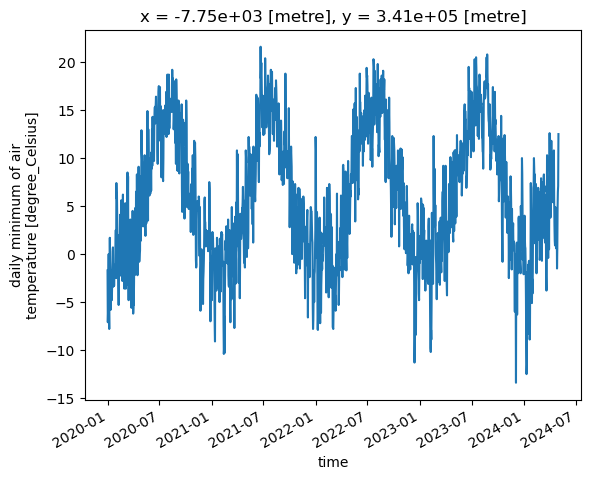

In [25]:
# spatiotemporal cube (2m max temperature)
# time series of one location
ds.TN.sel(x=-7700, y=341000, method='ffill').plot()

### Thematic spatial cube

In [135]:
# get all values from a list of locations, and convert to dataframe
cube.sel(x=-7700, y=341000, method='ffill').expand_dims('band').to_dataframe()

,x,y,spatial_ref,locker bebautes Wohn(misch)gebiet,Wohn(misch)gebiet mittlerer Dichte,dichtes Wohn(misch)gebiet,"grossvolumiger, solidaerer Wohn(misch)bau",Buero- und Verwaltungsviertel,solitaere Handelsstrukturen,"Geschaefts-, Kern- u. Mischgebiete",...,"Park, Gruenanlage","Sport und Bad (Outdoor), Camping",Friedhof,Acker,Weingarten,"Gaertnerei, Obstplantagen",Wald,Wiese,Gewaeser inkl. Bachbett,dem
band,,,,,,,,,,,,,,,,,,,,,
1,-7750.0,341050.0,0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,225.316086


In [136]:
# get AVG DEM -hight of urban green:

In [ ]:
# TODO get values in a neighborhood (window) of a given location